# 3D reconstruction using 2 image

Key References
- https://www.opencvhelp.org/tutorials/advanced/reconstruction-opencv/

In [2]:
from __future__ import annotations

import os
import random as rd
from typing import TYPE_CHECKING

import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyrender
import scipy.spatial.transform as sci_trans

from project_3d_reconstruction.rendering import render_helper as rh

if TYPE_CHECKING:
    from mpl_toolkits.mplot3d.axes3d import Axes3D

# Generate simple scene

In [11]:
FILE_PATH = os.path.abspath(
    os.path.join(
        os.path.abspath("pyrender_basic_reconstruction.ipynb"), "..", "..", "mesh_files"
    )
)
OBJECTS = [
    os.path.join(FILE_PATH, "pyrender_examples", "drill.obj"),
    os.path.join(FILE_PATH, "coral_2", "untitled.dae"),
]

renderer = rh.RenderHelper()

# Load in mesh files
names = []
for file_path in OBJECTS:
    print(f"Loading {file_path}")
    name = file_path.split("\\")[-2]  # warning slash is different for linux vs windows
    names.append(name)
    renderer.loadFromPath(file_path, name)
print("Done loading")

# Place them in the world
renderer.addFromMeshDict("coral_2", rh.positionOnly(0, 0, 0))



Loading c:\Code\Project3DReconstruction\mesh_files\pyrender_examples\drill.obj
Loading c:\Code\Project3DReconstruction\mesh_files\coral_2\untitled.dae
Done loading


# test image from two perspectives.

In [12]:
# it got annoying making edits in render helper so its here now (TODO move it back)
# NOTE z is out, y is up (image y might be flipped), x is right
def toOriginPose2(x, y, z):
    # azimuth from xz plane
    az_rad = np.arctan2(x, z)
    # rotation about y axis
    Ry = np.array(
        [
            [np.cos(az_rad), 0, np.sin(az_rad)],
            [0, 1, 0],
            [-np.sin(az_rad), 0, np.cos(az_rad)],
        ]
    )

    el_rad = np.arctan2(-y, np.sqrt(x**2 + z**2))
    Rx = np.array(
        [
            [1, 0, 0],
            [0, np.cos(el_rad), -np.sin(el_rad)],
            [0, np.sin(el_rad), np.cos(el_rad)],
        ]
    )
    R = Ry @ Rx
    Rstack = np.hstack((R, np.array([[x, y, z]]).T))
    return np.vstack((Rstack, np.array([[0, 0, 0, 1]])))


# wrapper for easy even spacing
def toOriginPose3(az_rad, el_rad, radius):
    y = radius * np.sin(el_rad)
    rproj = radius * np.cos(el_rad)
    x = rproj * np.sin(az_rad)
    z = rproj * np.cos(az_rad)
    return toOriginPose2(x, y, z)



# save many images


In [13]:
# Render many views in a spiral pattern
poses = []
images = []
numPoses = 30
azSpacing = 2.0 * np.pi / numPoses
elSpacing = np.pi*2.0/(3*numPoses)
for i in range(numPoses):
    pose1 = toOriginPose3(azSpacing*2 * i, -np.pi/3.0+elSpacing*i, 0.8)
    renderer.moveCamera(pose1)
    renderer.render(show_image=False, image_filename="test" + str(i) + ".png")
    poses.append(pose1)
    # TODO optimize this out if we're low on memory
    images.append(cv.imread("test" + str(i) + ".png"))

# actual extrinsics
# print(pose1)
# print(pose2)
# relativePose = np.matmul(np.linalg.inv(pose1), pose2)
# print(relativePose)

gray_0 = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)
gray_1 = cv.cvtColor(images[1], cv.COLOR_BGR2GRAY)

# ifig, iaxs = plt.subplots(ncols=numPoses, figsize=(8, 8))
# for i in range(numPoses):
#     iaxs[i].imshow(images[i], origin="lower")
# ifig.tight_layout()

# Detect SIFT features

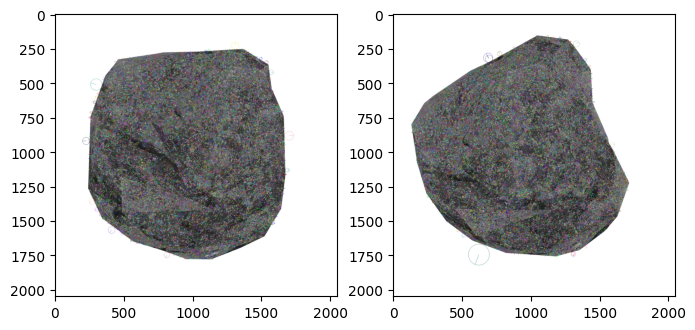

In [31]:
def opponentSIFT(img):
    # Step 1 convert to opponent color space
    # TODO optimize
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]

    O1 = np.divide((R - G), np.sqrt(2))
    O2 = np.divide((R + G - 2 * B), np.sqrt(6))
    O3 = np.divide((R + G + B), np.sqrt(3))
    # visually check opponent color space
    # cv.imwrite('sift_keypointsO1.jpg',np.uint8(O1))
    # cv.imwrite('sift_keypointsO2.jpg',np.uint8(O2))
    # cv.imwrite('sift_keypointsO3.jpg',np.uint8(O3))

    # Step 2 use Harris-Laplace point detector on intensity channel (o3)
    # TODO use a real point detector or figure out what parameters to use with cv SIFT
    # use this space to specify additional parameters
    sift = cv.SIFT_create()
    #sift = cv.SIFT_create(nfeatures=1000)

    kp = sift.detect(np.uint8(O3), None)

    # Step 3 compute descriptors for each opponent channel
    _, des1 = sift.compute(np.uint8(O1), kp)
    _, des2 = sift.compute(np.uint8(O2), kp)
    _, des3 = sift.compute(np.uint8(O3), kp)

    # combine into one large descriptor
    des = np.concatenate((des1, des2, des3), axis=1)

    return kp, des


kpList = []
desList = []
for i in range(numPoses):
    kp, des = opponentSIFT(images[i])
    kpList.append(kp)
    desList.append(des)

image_kp_1 = cv.drawKeypoints(
    gray_0, kpList[0], images[0], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_kp_2 = cv.drawKeypoints(
    gray_1, kpList[1], images[1], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

ifig, iaxs = plt.subplots(ncols=2, figsize=(8, 8))
iaxs[0].imshow(image_kp_1)
iaxs[1].imshow(image_kp_2)

# Match features (brute-force)

In [32]:
bf = cv.BFMatcher()

# matches between index i and i+1
bfMatchesList = []
for i in range(numPoses - 1):
    bf_matches = bf.knnMatch(desList[i], desList[i + 1], k=2)
    good = []

    for m, n in bf_matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
    bfMatchesList.append(good)

111


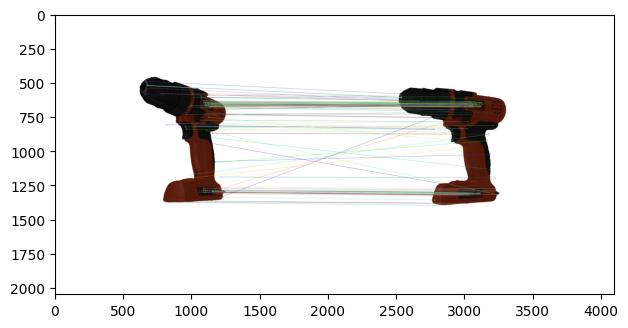

In [20]:

show_index = 13
image_matches = cv.drawMatchesKnn(
    images[show_index],
    kpList[show_index],
    images[show_index+1],
    kpList[show_index+1],
    bfMatchesList[show_index],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


ifig, iax = plt.subplots()
iax.imshow(image_matches)
ifig.tight_layout()
print(len(bfMatchesList[show_index]))

# Estimate essential matrix, filter points with ransac

In [21]:
# see pyrender script for intrinsic camera params
intrinsic_mat = np.array([[2048, 0, 1024], [0, 2048, 1024], [0, 0, 1]])

ransacMatches = []
fMatrices = []
for i in range(numPoses - 1):
    good = bfMatchesList[i]
    kp1 = kpList[i]
    kp2 = kpList[i + 1]
    points_1 = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
    points_2 = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)

    fMatrix, mask = cv.findFundamentalMat(
        points_1,
        points_2,
        method=cv.FM_RANSAC,
        ransacReprojThreshold=3,
        confidence=1 - 1e-6,
    )

    postRansac = []
    for i in range(len(mask)):
        if mask[i]:
            postRansac.append(good[i])
    ransacMatches.append(postRansac)
    fMatrices.append(fMatrix)

TypeError: object of type 'NoneType' has no len()

[[ 0.94304728  0.33179959  0.02389273 -0.35441974]
 [-0.33211559  0.94317858  0.01064888  0.13526628]
 [-0.01900182 -0.01797755  0.99965781  0.92525115]]
[[ 0.91354546  0.33719996  0.22744424  0.11372212]
 [-0.35224427  0.93549249  0.02788868  0.01394434]
 [-0.20336832 -0.10559351  0.97339167 -0.01330417]]


(-1.0, 1.0)

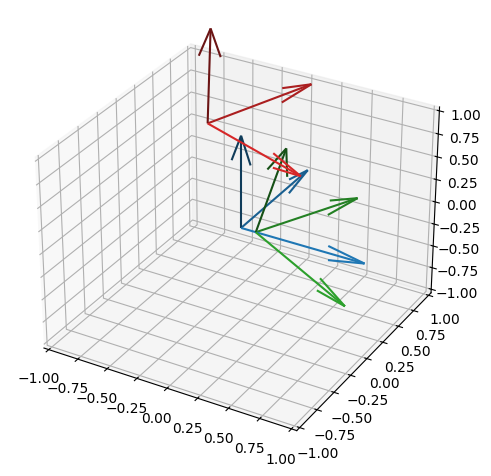

In [27]:
essential_mat = intrinsic_mat.T @ fMatrices[0] @ intrinsic_mat

good = ransacMatches[0]
kp1 = kpList[0]
kp2 = kpList[1]
points_1 = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
points_2 = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)

_, est_rot, est_trans, _ = cv.recoverPose(
    essential_mat, points_1, points_2, intrinsic_mat
)

est_extrinsic = np.hstack((est_rot, est_trans))

# act_rot = sci_trans.Rotation.align_vectors(dir_2, dir_1)[0].as_matrix()
# act_extrinsic = np.hstack((act_rot, np.reshape(dir_2 - dir_1, (-1, 1))))
# actual extrinsics
# print(pose1)
# print(pose2)
relativePose = np.matmul(np.linalg.inv(poses[0]), poses[1])
# print(relativePose)
act_extrinsic = relativePose[0:3, :]
print(est_extrinsic)
print(act_extrinsic)

origin = np.hstack((np.eye(3), np.zeros((3, 1))))

all_extrinsics = [origin, act_extrinsic, est_extrinsic]
base_colors = [
    mpl.colors.to_rgb("tab:blue"),
    mpl.colors.to_rgb("tab:green"),
    mpl.colors.to_rgb("tab:red"),
]
cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
for mat, color in zip(all_extrinsics, base_colors, strict=False):
    pos = mat[:, 3]
    for column, weight in zip(mat[:, :3].T, [1, 0.8, 0.5], strict=False):
        cax.quiver(*pos, *column, color=np.array(color) * weight)

cfig.tight_layout()
cax.set_xlim3d(-1, 1)
cax.set_ylim3d(-1, 1)
cax.set_zlim3d(-1, 1)
# cax.voxels(voxelarray, facecolors=colors, edgecolors=colors);

# note: rotation vectors stay aligned and translation is close enough (within scale factor)
# NOTE the chirality is messed up. pyrender camera has an inverted y axis. estimated translation will have the opposite direction

In [28]:
# turn feature points into 3D points using actual extrinsic matrix
points3DList = []
quality3DPointsList=[]
highErrorPts = 0
for i in range(numPoses - 1):
    relativePose = np.matmul(np.linalg.inv(poses[i]), poses[i + 1])
    R = relativePose[0:3, 0:3]
    T = relativePose[0:3, 3]

    kp1 = kpList[i]
    kp2 = kpList[i + 1]
    good = ransacMatches[i]

    points_1_pr = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
    points_2_pr = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)
    f = 2048.0
    points3D = np.zeros((len(points_1_pr), 3))
    currentPose = poses[i]
    for index in range(len(points_1_pr)):
        point1 = points_1_pr[index]
        point2 = points_2_pr[index]
        # NOTE inverting y axis here
        # also converting from pixels to camera frame
        ray1 = np.array([point1[0][0] - 1024, 1024 - point1[0][1], f])  # *a
        ray2 = R @ np.array([point2[0][0] - 1024, 1024 - point2[0][1], f])
        ray1 = ray1/np.linalg.norm(ray1)
        ray2 = ray2/np.linalg.norm(ray2)
        skewSegment = np.cross(ray1, ray2)
        skewSegment = skewSegment/np.linalg.norm(skewSegment)
        A = np.column_stack([ray1, -ray2, skewSegment])
        coeffs = np.linalg.solve(A, T)

        p13d = coeffs[0] * ray1
        p23d = T + coeffs[1] * ray2
        midpoint = (p13d + p23d) / 2.0

        # convert to world coordinates
        fourVec = np.concatenate([midpoint, [1]])
        point_worldCoords = (currentPose @ fourVec)[0:3]
        points3D[index] = point_worldCoords

        #warning, arbitrary threshold for filtering high error points
        if coeffs[2] < 1e-3:
            quality3DPointsList.append(point_worldCoords)

    points3DList.append(points3D)
print(points3DList[0])
print(points3DList[1])


[[ 0.11062301  0.05554327 -0.00913419]
 [ 0.11061369  0.05668053 -0.0097557 ]
 [ 0.11004512  0.05701695 -0.01122592]
 ...
 [-0.02338262 -0.05451294 -0.02833952]
 [-0.03141277  0.10319701 -0.05856491]
 [-0.02662014 -0.06563565 -0.02600057]]
[[ 0.10286706  0.0487745  -0.03440376]
 [ 0.10870916  0.05148584 -0.00788283]
 [ 0.06966318  0.08075365 -0.04181101]
 ...
 [-0.02553978 -0.06942521 -0.02497482]
 [-0.02857345 -0.05275026 -0.0250036 ]
 [-0.02874934 -0.04738163 -0.0085351 ]]


[ 0.02023865 -0.09870702 -0.0435619 ]


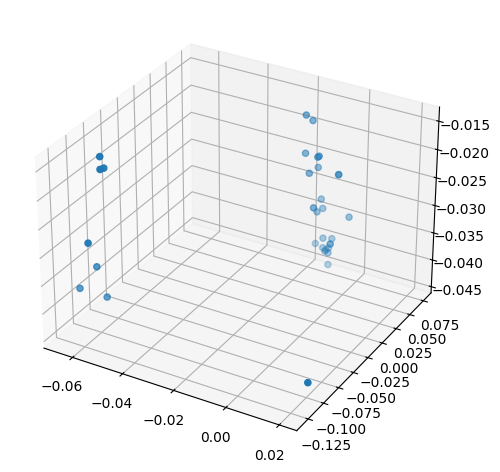

In [32]:
points3D = points3DList[18]
print(points3D[0])
# problem: sift feature points aren't always corners, not all corners make it to the final list either

cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
cax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2])
cfig.tight_layout()

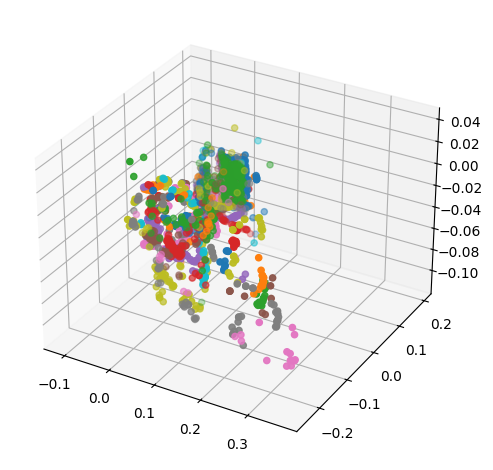

In [33]:
# all pts
cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
for points3D in points3DList:
    cax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2])
cfig.tight_layout()

In [34]:
import pyvista as pv
import trimesh

from project_3d_reconstruction.point_cloud_to_mesh import (
    point_cloud_to_mesh_tester as pcloud,
)

# # actual mesh
# coralFile = os.path.join(FILE_PATH, "coral_4", "untitled.dae")
# mesh = trimesh.load(coralFile, force="mesh")
# pc1 = pcloud.generatePointCloud(mesh, noise=0.0)
# clusters1 = pcloud.extractClusters(pc1, distance_threshold=0.5)

# # Plot it
# pl1 = pv.Plotter(shape=(1, 2))
# pl1.add_title("Point Cloud of 3D Surface")
# pl1.add_mesh(pc1)
# pl1.subplot(0, 1)
# pl1.add_title("Reconstructed Surface")
# for cluster in clusters1:
#     surf = pcloud.pointsToSurface(cluster)
#     pl1.add_mesh(surf, color=True, show_edges=True)

#uncomment this to show
#pl1.show()

In [36]:
flattenedPointsList = np.array(quality3DPointsList)
# flattenedPointsList = np.concatenate(points3DList)
print(flattenedPointsList)
print(numPoses)
#clusters = pcloud.extractClusters(flattenedPointsList, distance_threshold=0.5)

# Plot it
pl = pv.Plotter(shape=(1, 2))
pl.add_title("Point Cloud of 3D Surface")
pl.add_mesh(flattenedPointsList)
pl.subplot(0, 1)
pl.add_title("Reconstructed Surface")
# for cluster in clusters:
#     surf = pcloud.pointsToSurface(cluster)
#     pl.add_mesh(surf, color=True, show_edges=True)

#uncomment this to show
pl.show()

[[ 0.11062301  0.05554327 -0.00913419]
 [ 0.11061369  0.05668053 -0.0097557 ]
 [ 0.11004512  0.05701695 -0.01122592]
 ...
 [-0.04813427 -0.0931777  -0.04571006]
 [-0.04659178 -0.07486001 -0.0451337 ]
 [-0.0478104  -0.07737016 -0.04493469]]
30


Widget(value='<iframe src="http://localhost:53508/index.html?ui=P_0x1e70f9a3cb0_4&reconnect=auto" class="pyvis…